<a href="https://github.com/linogaliana/python-datascientist/blob/master/course/NLP/03_lda.ipynb" class="github"><i class="fab fa-github"></i></a>
[![Download](https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter)](https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/course/NLP/03_lda.ipynb)
[![nbviewer](https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter)](https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/course/NLP/03_lda.ipynb)
[![Onyxia](https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&color=yellow?logo=Python)](https://datalab.sspcloud.fr/launcher/inseefrlab-helm-charts-datascience/jupyter?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABcourse/NLP%2003_lda
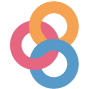

In [1]:
#| echo: false
#| output: 'asis'
#| include: true
#| eval: true

import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/NLP/03_lda.qmd")

Cette page approfondit les exercices présentés dans la 
[section précédente](#nlpexo). 
On va ainsi continuer notre exploration de la littérature anglophones :

* Edgar Allan Poe, (EAP) ;
* HP Lovecraft (HPL) ;
* Mary Wollstonecraft Shelley (MWS).

Les données sont disponibles ici : [spooky.csv](https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/blob/master/data/spooky.csv) et peuvent être requétées via l'url 
<https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv>.


Le but va être dans un premier temps de regarder dans le détail les termes les plus fréquents utilisés par les auteurs, et les représenter graphiquement.

<!-- puis on va ensuite essayer de prédire quel texte correspond à quel auteur à partir d'un modèle `Word2Vec`. -->


Ce notebook est librement inspiré de  : 

* https://www.kaggle.com/enerrio/scary-nlp-with-spacy-and-keras
* https://github.com/GU4243-ADS/spring2018-project1-ginnyqg
* https://www.kaggle.com/meiyizi/spooky-nlp-and-topic-modelling-tutorial/notebook

La LDA est une technique d'estimation bayésienne.
Le [poly d'Alberto Brietti](http://alberto.bietti.me/files/rapport-lda.pdf)
sur le sujet constitue une très bonne ressource pour comprendre
les fondements de cette technique. 


## Librairies nécessaires

Cette page évoquera les principales librairies pour faire du NLP, notamment : 

* [WordCloud](https://github.com/amueller/word_cloud)
* [nltk](https://www.nltk.org/)
* [spacy](https://spacy.io/)
* [Keras](https://keras.io/)
* [TensorFlow](https://www.tensorflow.org/)


{{% box status="warning" title="Warning" icon="fa fa-exclamation-triangle" %}}
Comme dans la [partie précédente](#nlpexo), il faut télécharger quelques
éléments pour que `NTLK` puisse fonctionner correctement. Pour cela, faire:

~~~python
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
~~~
{{% /box %}}


La liste des modules à importer est assez longue, la voici:


In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('genesis')
nltk.download('wordnet')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from wordcloud import WordCloud
#from IPython.display import display
import base64
import string
import re
import nltk

from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

[nltk_data] Downloading package stopwords to /github/home/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /github/home/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package genesis to /github/home/nltk_data...
[nltk_data]   Package genesis is already up-to-date!
[nltk_data] Downloading package wordnet to /github/home/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Données utilisées

*Si vous avez déjà lu la section précédente et importé les données, vous
pouvez passer à la section suivante*

Le code suivant permet d'importer le jeu de données `spooky`: 


In [3]:
import pandas as pd

url='https://github.com/GU4243-ADS/spring2018-project1-ginnyqg/raw/master/data/spooky.csv'
import pandas as pd
train = pd.read_csv(url,
                    encoding='latin-1')
train.columns = train.columns.str.capitalize()
                    
train['ID'] = train['Id'].str.replace("id","")
train = train.set_index('Id')

Le jeu de données met ainsi en regard un auteur avec une phrase qu'il a écrite:


In [4]:
train.head()

,Text,Author,ID
Id,,,
id26305,"This process, however, afforded me no means of...",EAP,26305
id17569,It never once occurred to me that the fumbling...,HPL,17569
id11008,"In his left hand was a gold snuff box, from wh...",EAP,11008
id27763,How lovely is spring As we looked from Windsor...,MWS,27763
id12958,"Finding nothing else, not even gold, the Super...",HPL,12958


Les étapes de *preprocessing* sont expliquées dans le [chapitre précédent](#nlpexo). On applique les étapes suivantes :

1. Tokeniser
2. Retirer la ponctuation et les stopwords
3. Lemmatiser le texte


In [5]:
lemma = WordNetLemmatizer()

train_clean = (train
    .groupby(["ID","Author"])
    .apply(lambda s: nltk.word_tokenize(' '.join(s['Text'])))
    .apply(lambda words: [word for word in words if word.isalpha()])
)

from nltk.corpus import stopwords  
stop_words = set(stopwords.words('english'))

train_clean = (train_clean
    .apply(lambda words: [lemma.lemmatize(w) for w in words if not w in stop_words])
    .reset_index(name='tokenized')
)

train_clean.head(2)

,ID,Author,tokenized
0,00001,MWS,"[Idris, well, content, resolve, mine]"
1,00002,HPL,"[I, faint, even, fainter, hateful, modernity, ..."


## Principe de la LDA (Latent Dirichlet Allocation)

Le modèle __Latent Dirichlet Allocation (LDA)__ est un modèle probabiliste génératif qui permet
de décrire des collections de documents de texte ou d’autres types de données discrètes. LDA fait
partie d’une catégorie de modèles appelés _“topic models”_, qui cherchent à découvrir des structures
thématiques cachées dans des vastes archives de documents.


Ceci permet d’obtenir des méthodes
efficaces pour le traitement et l’organisation des documents de ces archives: organisation automatique
des documents par sujet, recherche, compréhension et analyse du texte, ou même résumer des
textes. 

Aujourd’hui, ce genre de méthodes s’utilisent fréquemment dans le web, par exemple pour
analyser des ensemble d’articles d’actualité, les regrouper par sujet, faire de la recommandation
d’articles, etc. 

La LDA est une méthode qui considère les corpus comme des __mélanges__ de sujets et
de mots. Chaque document peut être représenté comme le résultat d'un mélange :

* de sujets
* et, au sein de ces sujets, d'un choix de mots.

L’estimation des
paramètres de la LDA passe par l’estimation des distributions des variables
latentes à partir des données observées (*posterior inference*). 
Mathématiquement, on peut se représenter la LDA comme une 
technique de maximisation de *log vraisemblance* avec un algorithme EM (*expectation maximisation*)
dans un modèle de mélange.

La matrice termes-documents qui sert de point de départ est la suivante:

|     | word_1 | word_2 | word_3 | ... | word_J |
|---- |--------|--------|--------|-----|--------|
|doc_1| 3      | 0      | 1      | ... | 0      |
| ... | ...    | ...    | ...    | ... | ...    |
|doc_N| 1      | 0      | 0      | ... | 5      |

On dit que cette matrice est *sparse* (creuse en Français) car elle contient principalement des 0. En effet, un document n'utilise qu'une partie mineure du vocabulaire complet. 

La LDA consiste à transformer cette matrice *sparse*document-terme en deux matrices de moindre dimension:

1. Une matrice document-sujet
2. Une matrice sujet-mots

En notant $K_i$ le sujet $i$. On obtient donc

* Une __matrice document-sujet__ ayant la structure suivante:

|     | K_1 | K_2 | K_3 | ... | K_M |
|---- |--------|--------|--------|-----|--------|
|doc_1| 1      | 0      | 1      | ... | 0      |
| ... | ...    | ...    | ...    | ... | ...    |
|doc_N| 1      | 1      | 1      | ... | 0      |

* Une __matrice sujets-mots__ ayant la structure suivante:

|     | word_1 | word_2 | word_3 | ... | word_J |
|---- |--------|--------|--------|-----|--------|
|K_1| 1      | 0      | 0      | ... | 0      |
| ... | ...    | ...    | ...    | ... | ...    |
|K_M| 1      | 1      | 1      | ... | 0      |

Ces deux matrices ont l'interprétation suivante :

* La première nous renseigne sur la présence d'un sujet dans un document
* La seconde nous renseigne sur la présence d'un mot dans un sujet

En fait, le principe de la LDA est de construire ces deux matrices à partir des fréquences d'apparition des mots dans le texte. 


On va se concentrer sur Edgar Allan Poe. 


In [6]:
corpus = train_clean[train_clean["Author"] == "EAP"]

## Entraîner une LDA

Il existe plusieurs manières d'entraîner une LDA.

Nous allons utiliser `scikit` ici avec la méthode `LatentDirichletAllocation`.
Comme expliqué dans la partie [modélisation](#modelisation) :

1. On initialise le modèle ;
2. On le met à jour avec la méthode `fit`.


In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(corpus['tokenized'].apply(lambda s: ' '.join(s)))

# Tweak the two parameters below
number_topics = 5
number_words = 10# Create and fit the LDA model
lda = LatentDirichletAllocation(n_components=11, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0,
                                n_jobs = 1)
lda.fit(count_data)

LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                          max_iter=5, n_components=11, n_jobs=1,
                          random_state=0)

## Visualiser les résultats

On peut déjà commencer par utiliser une fonction pour afficher les
résultats :


In [8]:
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

print_topics(lda, count_vectorizer, number_words)


Topic #0:
arm looking thousand respect hour table woman rest ah seen

Topic #1:
said dupin ha end write smith chair phenomenon quite john

Topic #2:
time thing say body matter course day place object immediately

Topic #3:
mere memory felt sat movement case sole green principle bone

Topic #4:
door room open small friend lady replied night window hand

Topic #5:
word man day idea good point house shall mind say

Topic #6:
eye figure form left sea hour ordinary life deep world

Topic #7:
foot great little earth let le year nature come nearly

Topic #8:
hand strange head color hair spoken read ear ghastly neck

Topic #9:
came looked shadow low dream like death light spirit tree

Topic #10:
eye know heart saw character far tell oh voice wall


/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



La représentation sous forme de liste de mots n'est pas la plus pratique...

On peut essayer de se représenter un *wordcloud* de chaque sujet pour mieux voir si cette piste est pertinente :


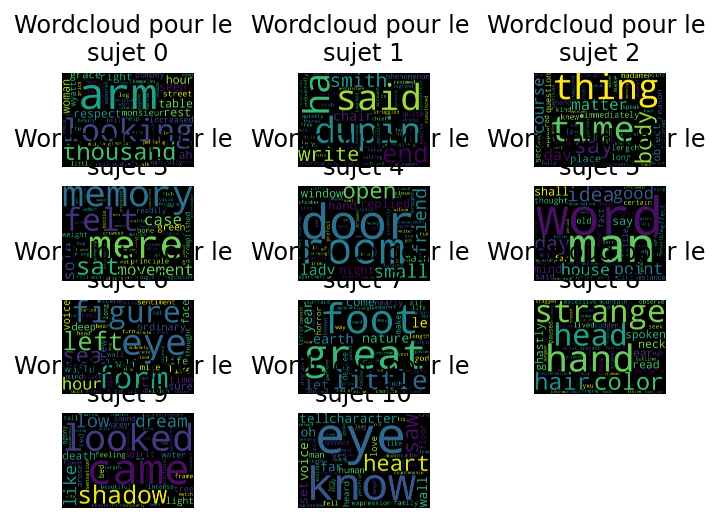

In [9]:
tf_feature_names = count_vectorizer.get_feature_names()

def wordcloud_lda(lda, tf_feature_names):

  fig, axs = plt.subplots(len(lda.components_) // 3 + 1, 3)
  
  for i in range(len(lda.components_)):
      corpus_lda = lda.components_[i]
      first_topic_words = [tf_feature_names[l] for l in corpus_lda.argsort()[:-50-1:-1]]
      k = i // 3
      j = (i - k*3)
      wordcloud = WordCloud(stopwords=stop_words, background_color="black",width = 2500, height = 1800)
      wordcloud = wordcloud.generate(" ".join(first_topic_words))
      axs[k][j].set_title("Wordcloud pour le \nsujet {}".format(i))
      axs[k][j].axis('off')
      axs[k][j].imshow(wordcloud)
  
  r = len(lda.components_) % 3
  [fig.delaxes(axs[len(lda.components_) // 3,k-1]) for k in range(r+1, 3+1) if r != 0]

wc = wordcloud_lda(lda, tf_feature_names)
wc

In [10]:
wc

Le module `pyLDAvis` offre quelques visualisations bien pratiques lorsqu'on
désire représenter de manière synthétique les résultats d'une LDA et observer la distribution sujet x mots.


{{% box status="hint" title="Hint" icon="fa fa-lightbulb" %}}
Dans un *notebook* faire :

~~~python
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()
~~~

Pour les utilisateurs de Windows, il est nécessaire d'ajouter l'argument
`n_jobs = 1`. Sinon, `python` tente d'entraîner le modèle avec de la 
parallélisation. Le problème est que les processus sont des FORKs, ce que
Windows ne supporte pas. Sur un système unix, on peut se passer de cet
argument. 

{{% /box %}}


In [11]:
#| output: hide

#!pip install pyLDAvis #à faire en haut du notebook sur colab
import pyLDAvis
import pyLDAvis.sklearn

# pyLDAvis.enable_notebook()
vis_data = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer, n_jobs = 1)
pyLDAvis.display(vis_data)

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning:

the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.



{{< rawhtml >}}


In [12]:
#| echo: false
#| output: asis
print(
  pyLDAvis.prepared_data_to_html(vis_data)
)


<link rel="stylesheet" type="text/css" href="https://cdn.jsdelivr.net/gh/bmabey/pyLDAvis@3.3.1/pyLDAvis/js/ldavis.v1.0.0.css">


<div id="ldavis_el4861406323075059682352597779"></div>
<script type="text/javascript">

var ldavis_el4861406323075059682352597779_data = {"mdsDat": {"x": [0.22997986654376687, 0.21575456063709605, 0.14993904608066747, -0.013211650550725602, -0.003097137883954287, -0.040036641387579994, -0.10397906156943486, -0.10671848939738458, -0.10573644701490148, -0.10416751874631433, -0.11872652671123429], "y": [-0.03025406845296497, -0.10160957954546743, 0.10032751215253355, 0.2196910333567761, 0.10996111106055492, -0.22688024884839914, 0.03556052606080631, -0.011783547632418626, -0.014034733346005565, -0.045409982118236505, -0.03556802268717906], "topics": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], "cluster": [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], "Freq": [20.499398170691858, 18.638194347963992, 13.691602068870054, 9.691393696960045, 8.76628621929609, 7.318475810226449, 6.02165

{{< /rawhtml >}}




* Chaque **bulle** représente un sujet. Plus la bulle est grande, plus il y a de documents qui traitent de ce sujet.

Plus les barres sont loin les unes des autres, plus elles sont différentes. Un bon modèle aura donc tendance à avoir de grandes bulles qui ne se recoupent pas. Ce n'est pas vraiment le cas ici...

* Les **barres bleues** représentent la fréquence de chaque mot dans le corpus.

* Les **barres rouges** représentent une estimation du nombre de termes générés dans un sujet précis. La barre rouge la plus longue correspond au mot le plus utilisé dans ce sujet. 


# Références

* Le [poly d'Alberto Brietti](http://alberto.bietti.me/files/rapport-lda.pdf)